In [33]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.3


# 기본 변수 정의

In [2]:
filename="2020KBO.csv"

# 베이지안 모델링을 적용할 두 팀
team1="NC"
team2="두산"

# 각 팀의 선발투수 이름 (전처리 과정에서 까먹고 안해서 이름 뒤에 빈칸 하나 포함시켜야 함)
ace1 = "구창모 "
ace2 = "플렉센 "

In [3]:
pd.read_csv(filename)

,Date,Home,Away,H_Score,A_Score,H_Pitcher,A_Pitcher
0,20200505,LG,두산,8,2,차우찬,알칸타라
1,20200505,SK,한화,0,3,킹엄,서폴드
2,20200505,삼성,NC,0,4,백정현,루친스키
3,20200505,KT,롯데,2,7,데스파이네,스트레일리
4,20200505,KIA,키움,2,11,양현종,브리검
...,...,...,...,...,...,...,...
688,20201030,SK,LG,3,2,윤희상,정찬헌
689,20201030,롯데,KIA,13,2,샘슨,가뇽
690,20201030,삼성,NC,4,4,원태인,구창모
691,20201030,한화,KT,4,3,김범수,배제성


# 1단계: 각 팀의 객관적 전력

In [4]:
#####################################
def preprocess(filename,team1,team2):
  df = pd.read_csv(filename)
  
  # 관심 있는 두 팀의 경기만 제외
  filter1 = (df.Home==team1) & (df.Away==team2)
  filter2 = (df.Home==team2) & (df.Away==team1)

  df1 = df[filter1 | filter2]      # 팀1 vs 팀2
  df = df.drop(df1.index, axis=0)  # 나머지 팀들
  
  # 팀 이름 인코딩 해주기
  teams = df.Home.unique()
  teams = pd.DataFrame(teams, columns=['team'])
  teams['i'] = teams.index
  
  df = pd.merge(df, teams, left_on='Home', right_on='team', how='left')
  df = df.rename(columns = {"i": "Home_encoded"}).drop("team", axis=1)
  
  df = pd.merge(df, teams, left_on='Away', right_on="team", how='left')
  df = df.rename(columns = {"i": "Away_encoded"}).drop("team", axis=1)
  
  for i in range(10):
    if teams['team'][i] == team1:
        team1num=teams['i'][i]
    if teams['team'][i] == team2:
        team2num=teams['i'][i]
  return df, df1, team1num, team2num, teams
#############################################

In [5]:
df,df1,team1_encoded,team2_encoded,teams=preprocess(filename,team1,team2)

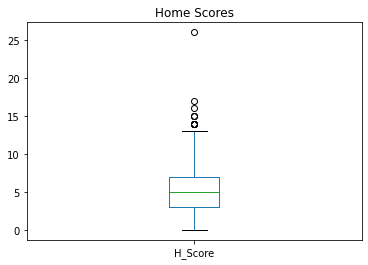

In [6]:
df.H_Score.plot(kind='box', title="Home Scores")

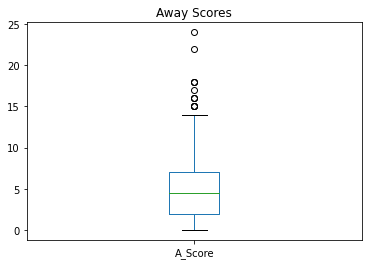

In [7]:
df.A_Score.plot(kind='box', title="Away Scores")

# 모델1: 각 팀별 attack & defense (team1, team2 간의 경기는 제외)

In [8]:
# 모델에 넣을 변수들
num_teams = 10
num_games = len(df)

home_team = df.Home_encoded.values
away_team = df.Away_encoded.values

observed_home_scores = df.H_Score
observed_away_scores = df.A_Score

In [9]:
## Hierarchical Bayesian Modeling using Pymc3

with pm.Model() as model:
    
    # first level (base parameter)
    intercept1 = pm.Flat("intercept1")
    sd_att = pm.HalfStudentT("sd_att", nu=3, sigma=2)
    sd_def = pm.HalfStudentT("sd_def", nu=3, sigma=2)
    
    # second level (team-specific parameters)
    attack_star = pm.Normal("attack_star", mu=0, sigma=sd_att, shape=num_teams)
    defense_star = pm.Normal("defense_star", mu=0, sigma=sd_def, shape=num_teams)
    
    attack = pm.Deterministic("attack", attack_star - T.mean(attack_star))     # 팀별 공격력을 평균이 0이 되도록 스케일링
    defense = pm.Deterministic("defense", defense_star - T.mean(defense_star)) # 팀별 수비력을 평균이 0이 되도록 스케일링
    
    theta_home = T.exp(intercept1 + attack[home_team] + defense[away_team])
    theta_away = T.exp(intercept1 + attack[away_team] + defense[home_team])
    
    # third level (likelihood)
    home_scores = pm.Poisson("home_scores", mu=theta_home, observed=observed_home_scores)
    away_scores = pm.Poisson("away_scores", mu=theta_away, observed=observed_away_scores)

In [10]:
with model:
    trace = pm.sample(tune=3000, draws=15000, target_accept=0.9) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defense_star, attack_star, sd_def, sd_att, intercept1]


Sampling 4 chains for 3_000 tune and 15_000 draw iterations (12_000 + 60_000 draws total) took 68 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
#######################################################

In [12]:
with model:
    summary = az.summary(trace, var_names=["intercept1", "attack", "defense"], round_to=2)
    
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept1,1.63,0.01,1.61,1.65,0.0,0.0,53519.91,53519.91,53528.48,44254.71,1.0
attack[0],0.08,0.03,0.02,0.14,0.0,0.0,125148.35,91791.00,125110.38,45763.34,1.0
attack[1],-0.13,0.04,-0.19,-0.06,0.0,0.0,113177.41,95756.00,113408.66,47018.16,1.0
attack[2],-0.05,0.04,-0.12,0.01,0.0,0.0,131162.30,69909.00,131280.36,44809.19,1.0
attack[3],0.08,0.03,0.02,0.14,0.0,0.0,115104.97,89140.90,115079.04,45117.34,1.0
attack[4],-0.01,0.04,-0.08,0.06,0.0,0.0,114136.12,26084.88,114126.92,44056.44,1.0
attack[5],0.08,0.04,0.01,0.15,0.0,0.0,116122.24,86020.22,116126.48,46018.90,1.0
attack[6],0.02,0.03,-0.04,0.09,0.0,0.0,115599.81,37209.94,115672.62,45071.30,1.0
attack[7],0.17,0.03,0.11,0.24,0.0,0.0,101936.26,96945.91,101936.55,48181.08,1.0
attack[8],0.04,0.03,-0.03,0.10,0.0,0.0,111748.27,52776.37,111738.00,45852.90,1.0


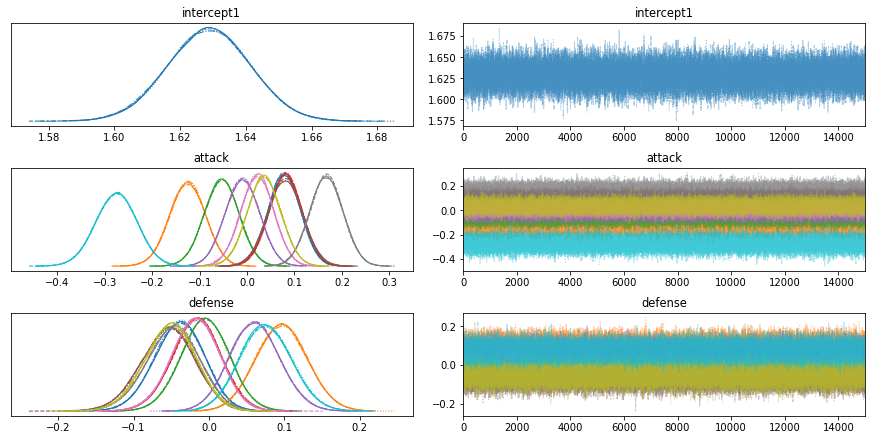

In [13]:
with model:
    pm.traceplot(trace, var_names=['intercept1', "attack", "defense"])
    plt.show()

# 모델 2: team1 vs team2 경기 추가

In [14]:
# 사후분포 사전분포로 재활용하기 위한 함수
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [15]:
################################################################

In [16]:
a = df1[(df1.Home == team1) & (df1.Away == team2)].A_Score  # team1의 홈경기에서의 실점수
b = df1[(df1.Home == team2) & (df1.Away == team1)].H_Score  # team1의 원정경기에서의 실점수

c = df1[(df1.Home == team2) & (df1.Away == team1)].A_Score  # team2의 홈경기에서의 실점수
d = df1[(df1.Home == team1) & (df1.Away == team2)].H_Score  # team2의 원정경기에서의 실점수

# 모델1의 posterior에서 재사용할 샘플들
t1_att_samples = trace["attack"][:, team1_encoded]          # team1의 attack parameter
t1_def_samples = trace['defense'][:, team1_encoded]         # team1의 defense parameter
t2_att_samples = trace['attack'][:, team2_encoded]          # team2의 attack parameter
t2_def_samples = trace['defense'][:, team2_encoded]         # team2의 defense parameter
intercept1_samples = trace['intercept1']                      # intercept parameter


observed_t1_scores = np.concatenate((c, d), axis=0).astype(int)  # team1의 득점수
observed_t2_scores = np.concatenate((b, a), axis=0).astype(int)  # team2의 득점수

In [17]:
observed_t1_scores

array([ 5,  1, 12,  9,  3,  5,  3,  5, 12,  1,  7, 10, 10,  8,  4])

In [18]:
with pm.Model() as model2:
    
    # Priors are posteriors from previous iteration
    intercept2 = from_posterior('intercept2', intercept1_samples)
    
    t1_att = from_posterior("t1_att", t1_att_samples)
    t1_def = from_posterior("t1_def", t1_def_samples)
    
    t2_att = from_posterior("t2_att", t2_att_samples)
    t2_def = from_posterior("t2_def", t2_def_samples)
    
    # intensity parameter
    theta_t1 = T.exp(intercept2 + t1_att + t2_def)
    theta_t2 = T.exp(intercept2 + t2_att + t1_def)
    
    # likelihood
    t1_score = pm.Poisson("t1_score", mu=theta_t1, observed=observed_t1_scores)
    t2_score = pm.Poisson("t2_score", mu=theta_t2, observed=observed_t2_scores)

In [19]:
with model2:
    trace2 = pm.sample(tune=3000, draws=15000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t2_def, t2_att, t1_def, t1_att, intercept2]


Sampling 4 chains for 3_000 tune and 15_000 draw iterations (12_000 + 60_000 draws total) took 53 seconds.


In [20]:
#######################################################################

In [21]:
with model2:
    summary2 = az.summary(trace2, round_to=2)
    
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept2,1.63,0.01,1.61,1.65,0.0,0.0,21032.79,19901.22,52774.75,37133.57,1.0
t1_att,0.18,0.03,0.12,0.24,0.0,0.0,57209.04,51898.80,59335.47,43444.16,1.0
t1_def,-0.04,0.03,-0.10,0.02,0.0,0.0,50197.77,29838.44,60420.35,41370.68,1.0
t2_att,0.09,0.03,0.03,0.16,0.0,0.0,50866.03,33857.98,56161.93,41349.79,1.0
t2_def,-0.05,0.03,-0.11,0.01,0.0,0.0,59696.77,41448.21,63053.03,43662.50,1.0


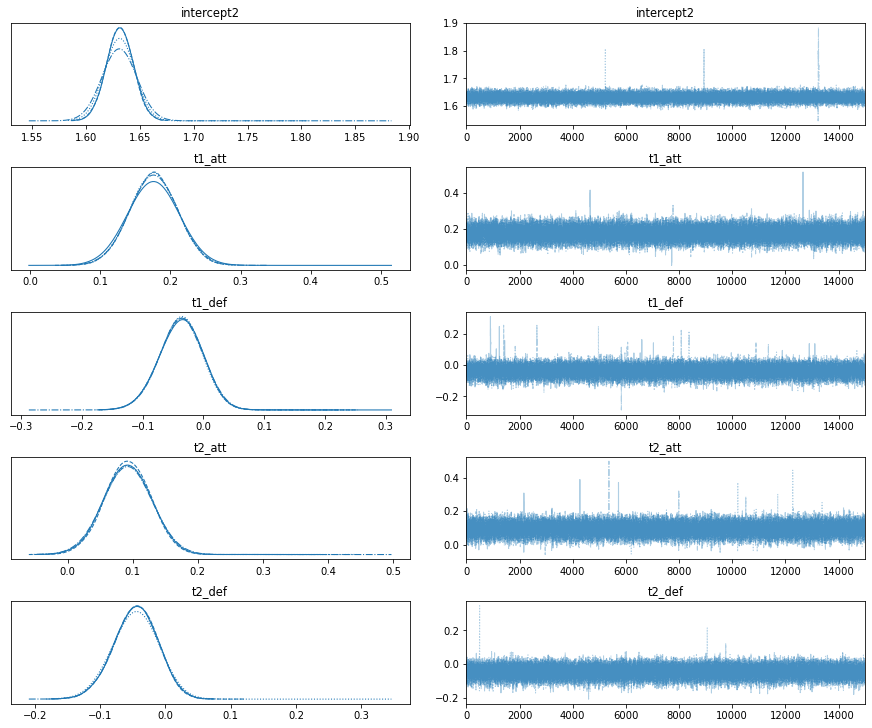

In [22]:
with model2:
    pm.traceplot(trace2, var_names=["intercept2", "t1_att", "t1_def", "t2_att", "t2_def"])
    plt.show()

In [112]:
with model2:
    t1_att_ess = az.ess(trace2["t1_att"]) - 12000
    t1_def_ess = az.ess(trace2["t1_def"]) - 12000
    t2_att_ess = az.ess(trace2["t2_att"]) - 12000
    t2_def_ess = az.ess(trace2["t2_def"]) - 12000

In [117]:
int(t1_att_ess)

47303

In [123]:
print("ESS of {}: {}".format("NC Attack", int(t1_att_ess)))
print("ESS of {}: {}".format("NC Defense", int(t1_def_ess)))
print("ESS of {}: {}".format("Doosan Attack", int(t2_att_ess)))
print("ESS of {}: {}".format("Doosan Attack", int(t2_def_ess)))

ESS of NC Attack: 47303
ESS of NC Defense: 48359
ESS of Doosan Attack: 44152
ESS of Doosan Attack: 51035


# 각 팀별 선발투수 고려

---

- 각 팀의 선발투수의 가장 최근 5경기의 가중평균을 보정치로 사용한다.
- 보정치는 후에 score를 시뮬레이션 하는 과정에서 포아송 regression에 더해짐.
- 각 팀의 선발투수의 실점수를 팀 내 다른 투수들과 비교해서 보정치로 사용한다.
- 이 보정치는 후에 score를 시뮬레이션 하는 과정에서 포아송 regression에 곱해짐.

## 선발투수의 최근 성적

In [23]:
from sklearn.preprocessing import scale

# team1의 선발투수의 이번 시즌 경기들
dat1 = df[(df.A_Pitcher == ace1) | (df.H_Pitcher == ace1)]
ace1_scores = []
for index, data in dat1.iterrows():
    if data.A_Pitcher == ace1:
        ace1_scores.append(data.H_Score)
    elif data.H_Pitcher == ace1:
        ace1_scores.append(data.A_Score)

# team2의 선발투수의 이번 시즌 경기들
dat2 = df[(df.A_Pitcher == ace2) | (df.H_Pitcher == ace2)]
ace2_scores = []
for index, data in dat2.iterrows():
    if data.A_Pitcher == ace2:
        ace2_scores.append(data.H_Score)
    elif data.H_Pitcher == ace2:
        ace2_scores.append(data.A_Score)

In [24]:
print(ace1_scores)
print(ace2_scores)

[2, 0, 2, 7, 2, 3, 1, 2, 4, 1, 5, 4]
[3, 4, 4, 8, 3, 6, 2, 6, 5, 2, 4, 5, 7, 2, 0, 1, 1, 0]


In [25]:
# 각 팀의 선발투수별 실점 를 스케일링
ace1_scores_scaled = scale(ace1_scores)
ace2_scores_scaled = scale(ace2_scores)

# 각 팀의 선발투수별 최근 5경기의 가중평균 값
ace1_weighted = np.average(ace1_scores_scaled[-5:], weights=[1,2,3,4,5])
ace2_weighted = np.average(ace2_scores_scaled[-5:], weights=[1,2,3,4,5])

print(ace1_weighted)
print(ace2_weighted)

0.4174686561832679
-1.265663763368756


In [26]:
# 최종 보정치
mean = np.mean([ace1_weighted, ace2_weighted])
ace1_rev = (ace1_weighted - mean) * 0.1
ace2_rev = (ace2_weighted - mean) * 0.1

print(ace1_rev)
print(ace2_rev)

0.0841566209776012
-0.0841566209776012


## 선발투수의 팀 내 성적

In [27]:
# team1의 선발 투수의 방어력 계산하기

df_new = pd.read_csv(filename)
df_team1_home = df_new[df_new.Home == team1]  # team1의 홈 경기들
df_team1_away = df_new[df_new.Away == team1]  # team1의 원정 경기들

# team1의 선발투수의 홈/원정 경기에서의 실점 수
ace1_home = sum(df_team1_home[df_team1_home.H_Pitcher == ace1].A_Score)
ace1_away = sum(df_team1_away[df_team1_away.A_Pitcher == ace1].H_Score)


# team1의 나머지 투수들의 홈/원정 경기에서의 실점 수
other_home = sum(df_team1_home[df_team1_home.H_Pitcher != ace1].A_Score)
other_away = sum(df_team1_away[df_team1_away.A_Pitcher != ace1].H_Score)


# team1의 선발 투수의 총 실점수
ace1_total = ace1_home + ace1_away

# team1의 선발 투수의 총 경기수
ace1_num_plays = len(df_team1_home[df_team1_home.H_Pitcher == ace1]) + len(df_team1_away[df_team1_away.A_Pitcher == ace1])

# team1의 나머지 투수들의 총 실점수
other_total = other_home + other_away

# team1의 나머지 투수들의 총 경기수
other_num_plays = len(df_team1_home[df_team1_home.H_Pitcher != ace1]) + len(df_team1_away[df_team1_away.A_Pitcher != ace1])


# team1의 선발투수의 평균 실점수
ace1_mean = ace1_total/ace1_num_plays

# team1의 나머지 투수들의 평균 실점수
other_mean = other_total/other_num_plays

# team1의 선발투수의 방어력에 대한 Prior
ace1_prior = ace1_mean/other_mean

ace1_prior

0.5350908872035633

In [28]:
# team2의 선발 투수의 방어력 계산하기

df_new = pd.read_csv(filename)
df_team2_home = df_new[df_new.Home == team2]  # team2의 홈 경기들
df_team2_away = df_new[df_new.Away == team2]  # team2의 원정 경기들

# team2의 선발투수의 홈/원정 경기에서의 실점 수
ace2_home = sum(df_team2_home[df_team2_home.H_Pitcher == ace2].A_Score)
ace2_away = sum(df_team2_away[df_team2_away.A_Pitcher == ace2].H_Score)


# team2의 나머지 투수들의 홈/원정 경기에서의 실점 수
other2_home = sum(df_team2_home[df_team2_home.H_Pitcher != ace2].A_Score)
other2_away = sum(df_team2_away[df_team2_away.A_Pitcher != ace2].H_Score)


# team2의 선발 투수의 총 실점수
ace2_total = ace2_home + ace2_away

# team2의 선발 투수의 총 경기수
ace2_num_plays = len(df_team2_home[df_team2_home.H_Pitcher == ace2]) + len(df_team2_away[df_team2_away.A_Pitcher == ace2])

# team2의 나머지 투수들의 총 실점수
other2_total = other2_home + other2_away

# team2의 나머지 투수들의 총 경기수
other2_num_plays = len(df_team2_home[df_team2_home.H_Pitcher != ace2]) + len(df_team2_away[df_team2_away.A_Pitcher != ace2])


# team2의 선발투수의 평균 실점수
ace2_mean = ace2_total/ace2_num_plays

# team2의 나머지 투수들의 평균 실점수
other2_mean = other2_total/other2_num_plays

# team2의 선발투수의 방어력에 대한 Prior
ace2_prior = ace2_mean/other2_mean

ace2_prior

0.7000946073793756

# 경기 결과 시뮬레이션

## team1의 득점 수

In [29]:
intercept_samples = trace2["intercept2"]
t1_att_samples = trace2["t1_att"]
t2_def_samples = trace2["t2_def"]

theta_team1 = np.exp(intercept_samples + t1_att_samples + t2_def_samples + ace2_rev) * ace2_prior
theta_team1

array([3.98164057, 3.94229435, 3.74272906, ..., 3.27128216, 3.68037986,
       3.71354198])

In [83]:
# Confidence Limits
theta1_lower_bound = sorted(theta_team1)[1500]
theta1_upper_bound = sorted(theta_team1)[-1500]

95% HDI: [3.428687882151346, 4.094155936215048]


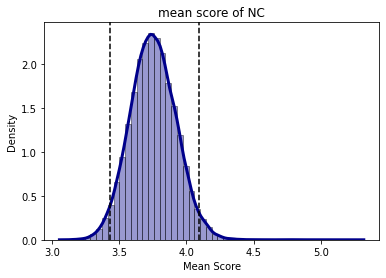

95% HDI: [3.428687882151346, 4.094155936215048]


In [85]:
ax1 = sns.distplot(theta_team1, hist=True, kde=True,
             color="darkblue", hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

ax1.set_title("mean score of NC")
ax1.set(xlabel="Mean Score", ylabel="Density")

# 95% HDI
ax1.axvline(theta1_lower_bound, color='black', linestyle="--")
ax1.axvline(theta1_upper_bound, color='black', linestyle="--")
plt.show()
print("95% HDI: {}".format([theta1_lower_bound, theta1_upper_bound]))

Text(0.5, 1.0, 'Simulated Scores of NC')

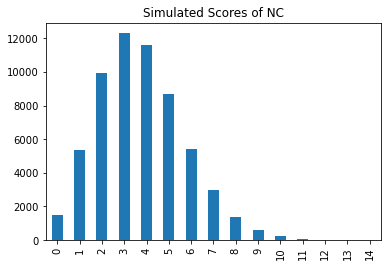

In [50]:
# team2의 샘플링된 득점 수의 분포
pd.Series(np.random.poisson(theta_team1)).value_counts().sort_index().plot(kind='bar').set_title("Simulated Scores of NC")

## team2의 득점 수

In [35]:
t2_att_samples = trace2["t2_att"]
t1_def_samples = trace2["t1_def"]

theta_team2 = np.exp(intercept_samples + t2_att_samples + t2_def_samples + ace1_rev) * ace1_prior
theta_team2

array([3.08952099, 3.12192381, 3.04108099, ..., 2.8366473 , 3.19053783,
       3.20012691])

In [86]:
# Confidence Limits
theta2_lower_bound = sorted(theta_team2)[1500]
theta2_upper_bound = sorted(theta_team2)[-1500]

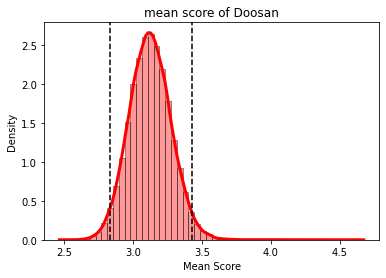

95% HDI: [2.8352082806755425, 3.425063552167059]


In [88]:
ax2 = sns.distplot(theta_team2, hist=True, kde=True,
             color="red", hist_kws={'edgecolor':'black'}, 
             kde_kws={'linewidth': 3})
ax2.set_title("mean score of Doosan")
ax2.set(xlabel="Mean Score", ylabel="Density")

# 95% HDI
ax2.axvline(theta2_lower_bound, color='black', linestyle="--")
ax2.axvline(theta2_upper_bound, color='black', linestyle="--")
plt.show()
print("95% HDI: {}".format([theta2_lower_bound, theta2_upper_bound]))

Text(0.5, 1.0, 'Simulated Scores of Doosan')

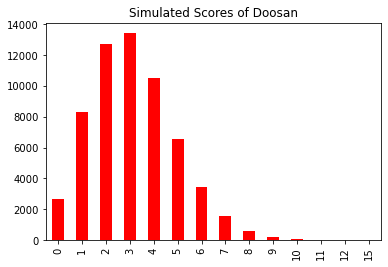

In [53]:
# team2의 샘플링된 득점 수의 분포
pd.Series(np.random.poisson(theta_team2)).value_counts().sort_index().plot(kind='bar', color="red").set_title("Simulated Scores of Doosan")

## 경기 결과 시뮬레이션

In [38]:
#team1을 기준으로 승/패 시뮬레이션 하기

result = []
difference = []
team1_scores_list = []
team2_scores_list = []
tally = 0

for i in range(1000000):
    """
    베이지안 모델을 사용해 뽑은 각 팀별 score intensity parameter에 대한 posterior 샘플들을 이용해
    경기 결과를 시뮬레이션 한다.
    야구에서 무승부가 나오는 경우는 드물기 때문에 무승부가 나올 경우 score를 한번 더 뽑음
    """
    team1_param = np.random.choice(theta_team1)
    team2_param = np.random.choice(theta_team2)
    
    team1_score = np.random.poisson(team1_param)
    team2_score = np.random.poisson(team2_param)
    if team1_score == team2_score:
        team1_score = np.random.poisson(team1_param)
        team2_score = np.random.poisson(team2_param)
    
    # 경기 결과 기록
    if team1_score > team2_score:
        result.append(1)
    elif team2_score > team1_score:
        result.append(-1)
    else:
        result.append(0)
    
    tally += 1
    difference.append(team1_score - team2_score)  # 득점 수 차이 -> 나중에 따로 분포를 파악해보기 위함.
    team1_scores_list.append(team1_score)
    team2_scores_list.append(team2_score)
    
    if tally % 100000 == 0:
        print("{}번의 경기 결과 시뮬레이션 완료".format(tally))

100000번의 경기 결과 시뮬레이션 완료
200000번의 경기 결과 시뮬레이션 완료
300000번의 경기 결과 시뮬레이션 완료
400000번의 경기 결과 시뮬레이션 완료
500000번의 경기 결과 시뮬레이션 완료
600000번의 경기 결과 시뮬레이션 완료
700000번의 경기 결과 시뮬레이션 완료
800000번의 경기 결과 시뮬레이션 완료
900000번의 경기 결과 시뮬레이션 완료
1000000번의 경기 결과 시뮬레이션 완료


In [39]:
simulated_result = pd.Series(result).value_counts()
print("준플레이오프 2차전 경기에서 {}이(가) {}을(를) 상대로 {}%의 확률로 승리합니다.".format(
    team1, team2, round((simulated_result[1])/sum(simulated_result)*100,2)))

준플레이오프 2차전 경기에서 NC이(가) 두산을(를) 상대로 59.54%의 확률로 승리합니다.


## bayesian statistical inference

### 각 팀별 득점 수의 분포

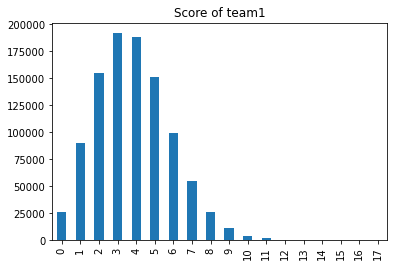

In [40]:
team1_stat = pd.Series(team1_scores_list).value_counts().sort_index()
team1_stat.plot(kind='bar', title="Score of team1")

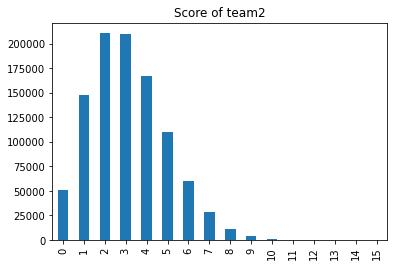

In [41]:
team2_stat = pd.Series(team2_scores_list).value_counts().sort_index()
team2_stat.plot(kind='bar', title="Score of team2")

### 각 팀별 득점 수의 신뢰구간

In [42]:
# team1의 득점 수에 대한 대략적인 95% 신뢰구간
print(sum(team1_stat[[0,1,2,3,4,5,6,7,8]])/sum(team1_stat))
print(sum(team1_stat[[0,1,2,3,4,5,6,7,8,9]])/sum(team1_stat))

0.982562
0.993691


### 양 팀의 득점수 차이

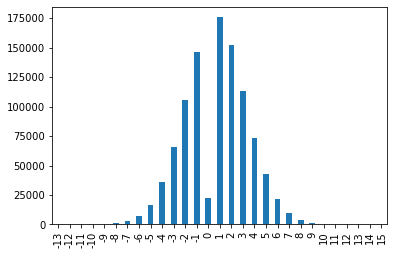

In [43]:
diff = pd.Series(difference).value_counts().sort_index()
diff.plot(kind='bar')

In [44]:
diff_sorted = diff.sort_values(ascending=False)

In [45]:
diff_sorted[:5]

 1    175781
 2    152324
-1    146381
 3    113605
-2    105769
dtype: int64

In [46]:
diff_sorted[diff_sorted.index > 0]

1     175781
2     152324
3     113605
4      73584
5      42434
6      21309
7      10030
8       4132
9       1532
10       487
11       165
12        48
13        13
14         4
15         1
dtype: int64

In [47]:
diff_sorted[4]/sum(diff_sorted[diff_sorted.index>0])

0.12357733407898913